## Final Project Part 3 - Technical Notebook

*Grace Campbell*

## The data

In [17]:
import pandas as pd
import numpy as np

vgsales = pd.read_csv('vgsales.csv')
vgsales.columns = ['rank', 'name', 'platform', 'year', 'genre', 'publisher', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'global_sales']

In [18]:
vgsales.head(10)

,rank,name,platform,year,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37
5,6,Tetris,GB,1989.0,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26
6,7,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01
7,8,Wii Play,Wii,2006.0,Misc,Nintendo,14.03,9.20,2.93,2.85,29.02
8,9,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,14.59,7.06,4.70,2.26,28.62
9,10,Duck Hunt,NES,1984.0,Shooter,Nintendo,26.93,0.63,0.28,0.47,28.31


This dataset contains information about the sales of video games from 1980 to 2016.

The data includes the name of each video game, the platform on which it was released, the year of release, the genre of video game, the publisher, and the number of sales in North America, Europe, Japan, other countries, and globally (all in millions).

I want to use this data to find out how the platform on which a video game is released will affect its sales in North America.

## Data preprocessing

I want to drop all rows that contain games from years earlier than 2000 and later than 2016. We have relatively less (and arguably less relevant) data on games earlier than 2000, and we cannot know the sales of a game that had not yet come out when this data was collected.

I also want to eliminate all platforms which have less than 30 games in the dataframe (small sample size).

In [41]:
vgsales.drop(vgsales[vgsales.year < 2000].index, inplace=True)
vgsales.drop(vgsales[vgsales.year > 2016].index, inplace=True)

vgsales.drop(vgsales[vgsales.platform == 'WS'].index, inplace=True)
vgsales.drop(vgsales[vgsales.platform == '2600'].index, inplace=True)
vgsales.drop(vgsales[vgsales.platform == 'GB'].index, inplace=True)

Here I'm going to map the platforms to numbers so I can more easily look at relationships. I'm going to group similar platforms into one category because I feel that I can better capture the relationship that way. For example, I'm grouping all handheld platforms together because I want a broader look at the popularity/sales of games on handheld platforms, not just the popularity/sales of games on, for example, the PSP or DS specifically. If I want to be able to generalize my findings, I need to be able to tell game makers that they should do "whatever" for handheld platforms as a whole.

In [42]:
# 1 = Handheld
# 2 = PlayStation Console
# 3 = XBox Console
# 4 = Wii
# 5 = PC
# 6 = Other (Extinct) Console

vgsales.loc[:, 'platform'] = vgsales.loc[:, 'platform'].map({'DS': 1, 'PS2': 2, 'PS3': 2, 'Wii': 4, 'X360': 3, 'PSP': 1, 
                                                                'PC': 5, 'XB': 3, 'GBA': 1, 'GC': 6, '3DS': 1, 'PSV': 1, 
                                                                'PS4': 2, 'PS': 2, 'XOne': 3, 'WiiU': 4, 'N64': 6, 'DC': 6})

To begin creating my model, I first need to create a new dataframe that contains dummy variables for *platform*, my feature of interest. If I do not take this step, my model may assign some sort of ordinal meaning to the numbers in the *platform* column.

In [43]:
vgsales_dummies = pd.get_dummies(vgsales, columns=['platform'], drop_first=True)

In [44]:
vgsales_dummies.columns[10:16]

Index(['y_pred', 'platform_2', 'platform_3', 'platform_4', 'platform_5',
       'platform_6'],
      dtype='object')

## Choosing a model

Now that I have my dataframe with dummy variables, I'm going to test three different models to see which gives me the lowest root mean squared error using a five-fold cross-validation.

In [45]:
# Matrix of features

# The feature I'm interested in is 'platform'. Since the dataframe I'm training contains dummy variables,
# I have to capture all dummy variable columns.
# My target variable is North American sales.

feature_cols = list(vgsales_dummies.loc[:, 'platform_2':'platform_6'])

X = vgsales_dummies.loc[:, feature_cols]
y = vgsales_dummies.loc[:, 'na_sales']

In [46]:
# Using a linear regression model

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Fitting the model and making predictions
linreg = LinearRegression()
linreg.fit(X, y)
linreg.predict(X)

# Computing the RMSE
scores = -cross_val_score(linreg, X, y, cv=5, scoring='neg_mean_squared_error')
np.mean(np.sqrt(scores))

0.5118369945442284

In [47]:
# Using a decision tree regression model

from sklearn.tree import DecisionTreeRegressor

treereg = DecisionTreeRegressor(max_depth=3, random_state=123)
treereg.fit(X, y)
treereg.predict(X)
# I chose a max depth of 3 since there are 5 different feature columns.

scores = -cross_val_score(treereg, X, y, cv=5, scoring='neg_mean_squared_error')
np.mean(np.sqrt(scores))

0.5122708835483435

In [48]:
# Using a random forest regression model

from sklearn.ensemble import RandomForestRegressor

rfreg = RandomForestRegressor(n_estimators=150, max_features=3, oob_score=True, random_state=123)
rfreg.fit(X, y)
rfreg.predict(X)
# I chose a max features of 3 since there are 5 different feature columns.

scores = -cross_val_score(rfreg, X, y, cv=5, scoring='neg_mean_squared_error')
np.mean(np.sqrt(scores))

0.5123913782803273

As we can see, my RMSE is lowest for the linear regression model, which I did not expect. However, in the interest of simplicity, interpretability, and accuracy, I will continue with the linear regression model for my data.

I decided to only focus on North American sales instead of global sales for two reasons. Firstly, when I ran the models with global sales as the target variable, my RMSE is much higher. Secondly, from a practical standpoint, my model stands to help game developers focus their efforts on a specific region for certain games, and is not necessarily meant to predict which games will be the most popular globally.

# Running the model

In [49]:
# Much the same as above, I will run the linear regression model and store its predictions as a variable.

feature_cols = list(vgsales_dummies.loc[:, 'platform_2':'platform_6'])

X = vgsales_dummies.loc[:, feature_cols]
y = vgsales_dummies.loc[:, 'na_sales']

linreg = LinearRegression()
linreg.fit(X, y)
y_pred = linreg.predict(X)

In [50]:
# A look at the coefficients for each feature variable

list(zip(feature_cols, linreg.coef_))

[('platform_2', 0.1249459411328298),
 ('platform_3', 0.22547461873245941),
 ('platform_4', 0.21909343023862504),
 ('platform_5', -0.08339421932896039),
 ('platform_6', 0.08650202573032768)]

In [51]:
vgsales.loc[:, 'y_pred'] = list(y_pred)

Text(0,0.5,'Prediction')

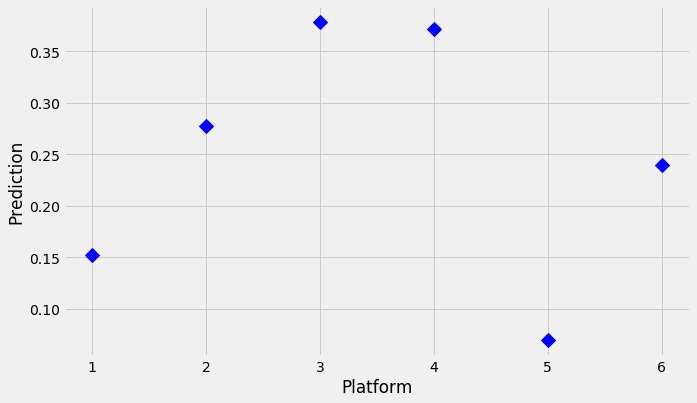

In [96]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
ax = vgsales.groupby('platform')['y_pred'].mean().plot(style='Db', figsize=(10, 6), markersize=10)
ax.set_xlabel('Platform')
ax.set_ylabel('Prediction')

## Conclusion

My linear regression model will predict the North American sales of a video game of a certain platform with a root mean squared error of 0.52, which equates to roughly $520,000. Of course, this is not an ideal error for a predictive model.

After some reflection I think that the variables in this dataset are not highly correlated enough to truly create a good predictive model with a linear regression. More exploration would have to be done with different models to find one with great predictive accuracy in a real-world business situation. 